# CLASSIFICATION OF SKIN CANCER LESIONS

Harun Burkuk - 21627045
Muhammet Subasi - 21627601

In this project, we try to a machine learning algorithm that diagnosis skin cancer by looking lesion images. 

### Table of Content

[Problem](#problem)   

[Data Understanding](#data_understanding)  

[Data Preparation](#data_preparation)

[Data Augmentation](#dataaugmentation) 

[Modeling](#modeling)  

[Evaluation](#evaluation) 
  
[References](#references)

### Problem <a class="anchor" id="problem"></a>[](http://)

For dermatologists, the first and most important thing used in diagnosing skin cancers is the examinations of the lesions that occur on the skin. Thanks to HAM10000, we have a data set collected from different subjects from different populations with various skin cancers. Now we will simulate how dermatologists diagnose the cancer type by looking at images of lesions using neural networks. We will try to diagnose the following 7 types of skin cancer;

1) Benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl)

2) Melanocytic nevi (nv)

3) Dermatofibroma (df)

4) Melanoma (mel)

5) Vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc)

6) Basal cell carcinoma (bcc)

7) Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec)

In [2]:
import os
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics

###  Data Understanding <a class="anchor" id="data_understanding"></a>
This dataset consists of 10015 dermatoscopic images of different ages, genders and confirmation authority belonging the different populations. We choose the 28X28x3 RGB pixel images considering the execution time. Let's look at the metadata to get more information about the data

In [3]:
meta=pd.read_csv('/content/data/HAM10000_metadata.csv')
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [4]:
tensorflow.test.gpu_device_name()

'/device:GPU:0'

In [5]:
meta.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [6]:
meta.shape

(10015, 7)

As can be seen below, most of the data belongs to the nv(melanocytic nevi) class. Rest of the dataset, seems to be evenly distributed.

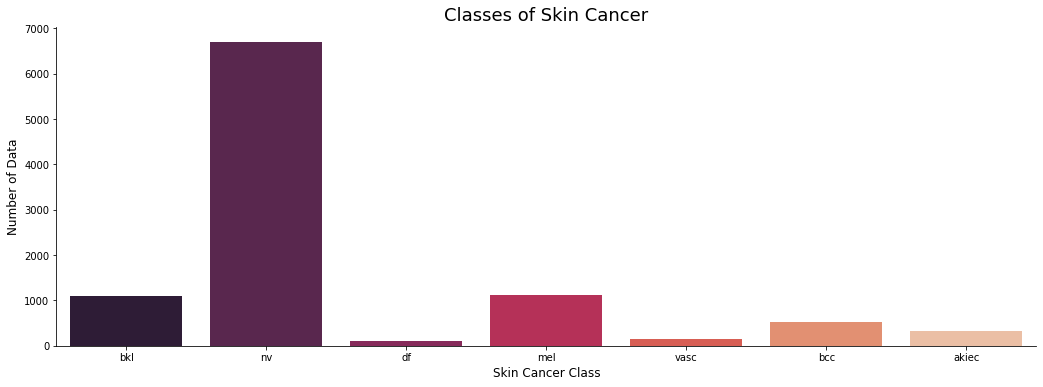

In [7]:
g = sns.catplot(x="dx", kind="count", palette='rocket', data=meta)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Classes of Skin Cancer', fontsize=18)
g.set_xlabels('Skin Cancer Class', fontsize=12)
g.set_ylabels('Number of Data', fontsize=12)

When we examine below graph, we see that most of the disease lesions are confirmed by histopathology or follow-up examination. This increases our confidence to the dataset. 

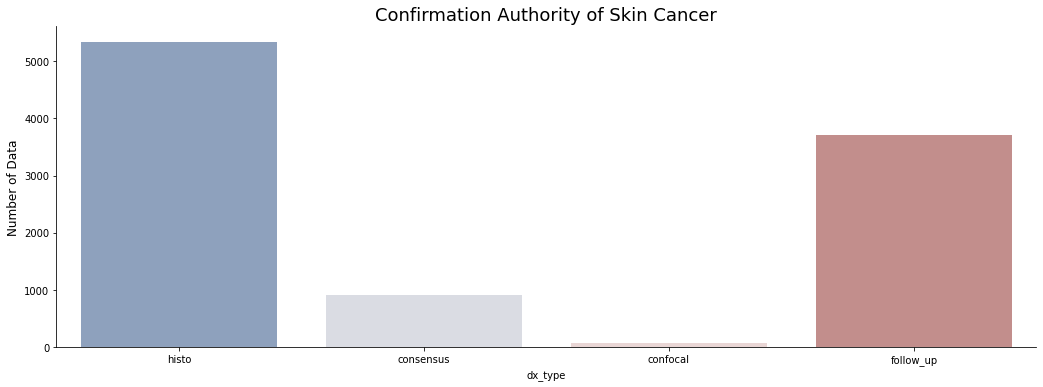

In [8]:
g = sns.catplot(x="dx_type", kind="count", palette='vlag', data=meta)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Confirmation Authority of Skin Cancer', fontsize=18)
g.set_ylabels('Number of Data', fontsize=12)

When we look at the distribution of skin cancer types by gender, we can say that all types of cancer are generally more common in men than women.

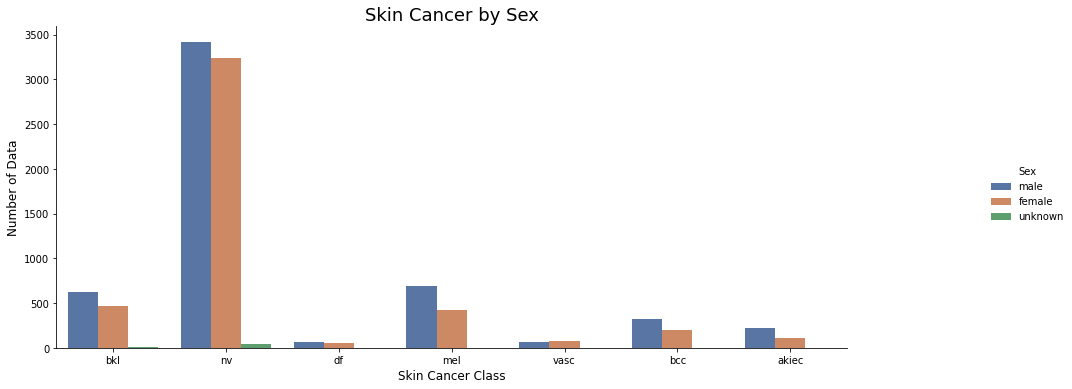

In [9]:
g = sns.catplot(x="dx", kind="count", hue="sex", palette='deep', data=meta)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Skin Cancer by Sex', fontsize=18)
g.set_xlabels('Skin Cancer Class', fontsize=12)
g.set_ylabels('Number of Data', fontsize=12)
g._legend.set_title('Sex')

As we can see in this graph below, the number of men is more than women, and there is also a small unknown data.

Text(0.5, 1.0, 'Gender of Patients')

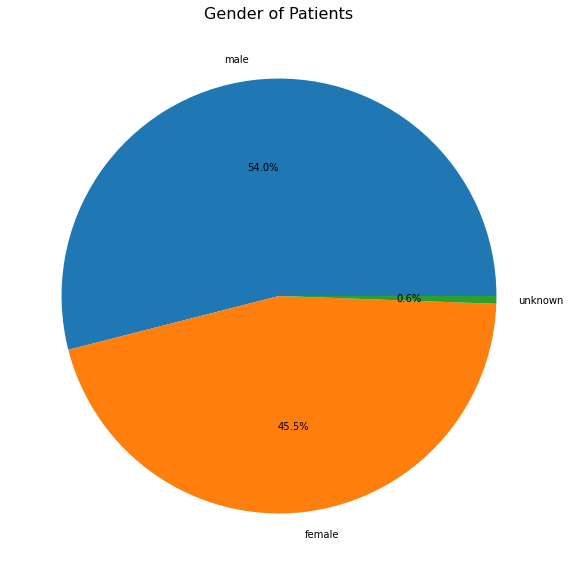

In [10]:
bar, ax = plt.subplots(figsize = (10,10))
plt.pie(meta['sex'].value_counts(), labels = meta['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Gender of Patients', size=16)

In the graphic below, we see the distribution of the dataset according to the location of the lesions in body parts. We can say that more lesions are seen on the back and lower extremity body parts.

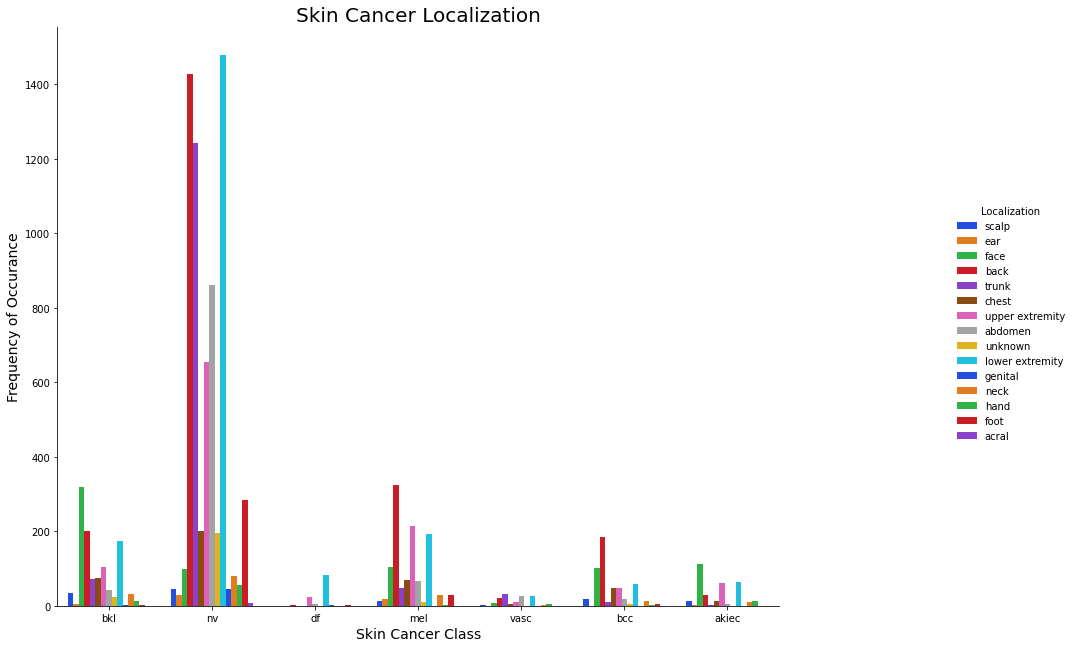

In [11]:
g = sns.catplot(x="dx", kind="count", hue="localization", palette='bright', data=meta)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer Localization', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)
g._legend.set_title('Localization')

Below, we look at the distribution of patient's ages by diseases.

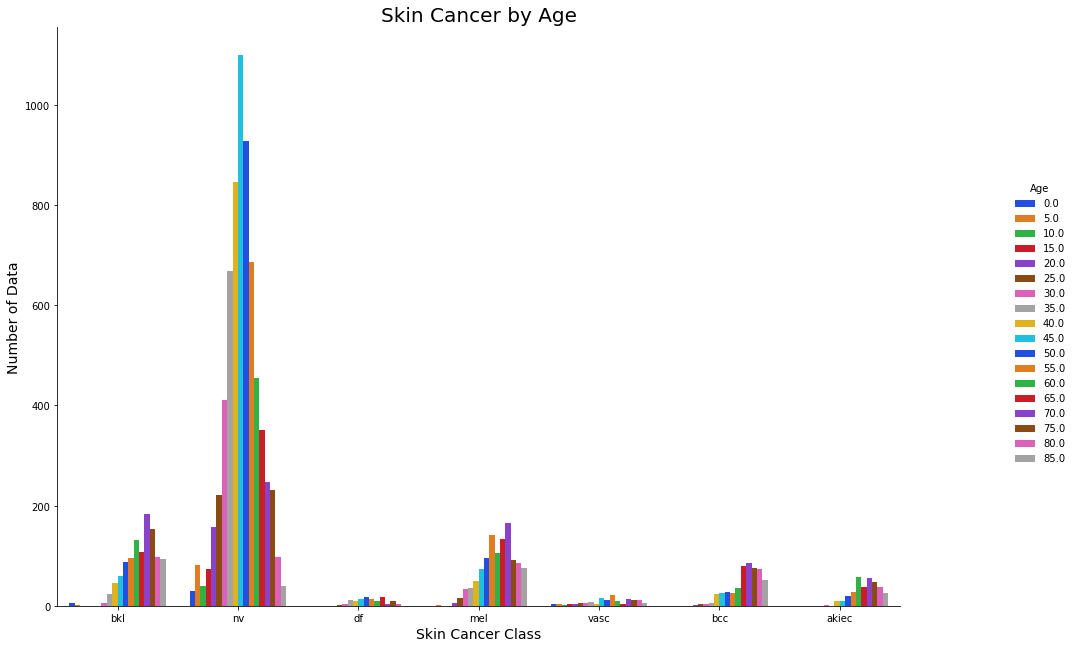

In [12]:
g = sns.catplot(x="dx", kind="count", hue="age", palette='bright', data=meta)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer by Age', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data', fontsize=14)
g._legend.set_title('Age')

Below, we see the histogram of the age distribution of patients regardless of their cancer type. 

In this dataset, we can say that there are mostly lesion samples from patients between the ages of 40 and 60

Text(0.5, 1.0, 'Histogram of Age of Patients')

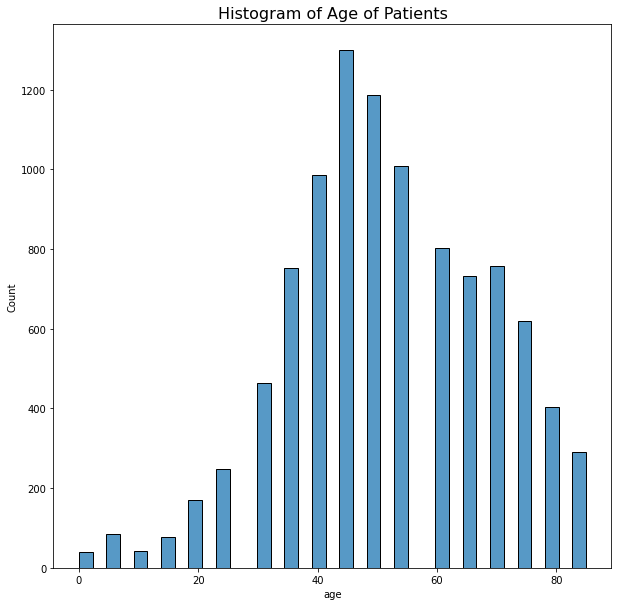

In [13]:
bar, ax = plt.subplots(figsize=(10,10))
sns.histplot(meta['age'])
plt.title('Histogram of Age of Patients', size=16)

# Data Preparation <a class="anchor" id="data_preparation"></a>

In data preparation part, let's first divide the pixels and the target labels(cancer types) into x and convert y to categorical format.

In [14]:
df=pd.read_csv('/content/data/hmnist_28_28_RGB.csv')
x=df.drop('label',axis=1)
y=df['label']
x=x.to_numpy()
x=x/255
y=to_categorical(y)

In [15]:
df['label'].value_counts()

4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: label, dtype: int64

In [16]:
label={
    'Actinic keratoses':0,
    'Basal cell carcinoma':1,
    'Benign keratosis-like lesions':2,
    'Dermatofibroma':3,
    'Melanocytic nevi':4,
    'Vascular lesions':5,
    'Melanoma':6
}

Reshape the data into 28x28x3 format. 28x28 is a pixel values and x3 for RGB values.



In [17]:
x_view=x.reshape(-1,28,28,3)
x = x.reshape(-1,28,28,3)

Show some examples from dataset

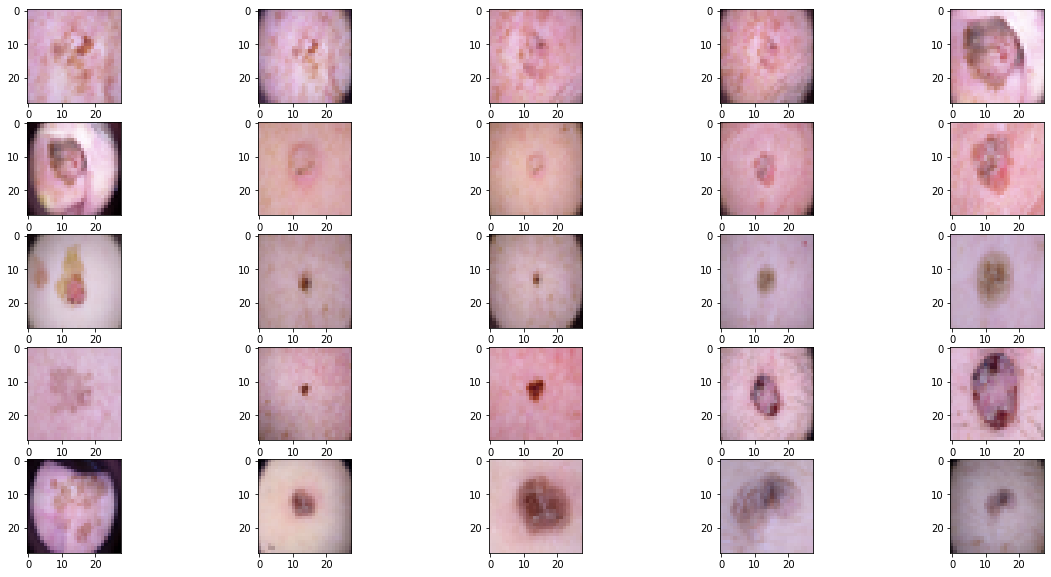

In [18]:
plt.figure(figsize=(20,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    img=x_view[i]
    plt.imshow(img)

# Data Augmentation <a class="anchor" id="dataaugmentation"></a>

Split the dataset into train and test with test size 20%.

In [19]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=1234)

In data augmentation part, we try to expand the training dataset in order to improve the performance and ability of the model to generalize. 

We use ImageDataGenerator class which is supported by Keras deep learning library. ImageDataGenerator creates transformed versions of images in the training dataset that belong to the same class as the original image. This transforms include range operations,shifts, flips, zooms.

In [20]:
datagen=ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='nearest')
datagen1=ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='nearest')

In [22]:
datagen.fit(X_train)
datagen1.fit(X_test)

# Modeling <a class="anchor" id="modeling"></a>

We used Sequential API models from tensorflow.keras.models. 

In first layer there are 2 convolutional (Conv2D) layer. We choosed to  32 filters for this layer. We used "relu" for activation function and apply kernel filter (3, 3) matrix on whole image.

In second layer  is the pooling (MaxPooling2D) layer. It can be say that this layer reduce overfitting by downsampling. If more the pooling dimension is high, more the downsampling is important.

Dropout is a regularization method which is randomly ignored some training samples by setting their weights zero. This technique improves generalization and  also reduces the overfitting.

The Flatten layer basically a convert layer which converts features to 1D vector.With this step Cnn bring together convolutional and pooling layers for learning more from images.

Lastly we used softmax to the outputs for getting predicted multinomial probability distributions. We used adams optimization algorithm for gradient descent for training models.It uses the squared gradients to scale the learning rate.

In [23]:
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import RMSprop

input_shape = (28, 28, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy',Recall(),tensorflow.keras.metrics.AUC()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

We optimized hyperparameters of CNN by try different values of hyperparameters. As you can see below we have batch_size_array, epoch_size_array, learning_rates arrays. We trained several times by resetting our model each time (so that model training is not cumulative).




In [24]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

# early=EarlyStopping(monitor='accuracy',patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_lr=0.0001)

In [90]:
batch_size_array = [32,64,128]
epoch_size_array = [5,25,50]
learning_rates = [1E-0,1E-2,1E-4]
acc_arr = []
val_loss_arr = []
model.save_weights("model.h5")
for b_size in batch_size_array:
  model.load_weights("model.h5")
  history_model = model.fit(X_train,y_train,batch_size=b_size,epochs=5,validation_split=0.2,callbacks=[reduce_lr])
  acc_arr.append(history_model.history['accuracy'])

max_acc = []
for i in acc_arr:
  print("Max Accuracy:",max(i))
  max_acc.append(max(i))



Epoch 1/5
201/201 [==============================] - 2s 8ms/step - loss: 0.6763 - accuracy: 0.7518 - recall: 0.6609 - auc: 0.9612 - val_loss: 0.6500 - val_accuracy: 0.7673 - val_recall: 0.6525 - val_auc: 0.9653
Epoch 2/5
201/201 [==============================] - 1s 7ms/step - loss: 0.6858 - accuracy: 0.7486 - recall: 0.6541 - auc: 0.9603 - val_loss: 0.6706 - val_accuracy: 0.7580 - val_recall: 0.6432 - val_auc: 0.9633
Epoch 3/5
201/201 [==============================] - 1s 7ms/step - loss: 0.6757 - accuracy: 0.7458 - recall: 0.6605 - auc: 0.9610 - val_loss: 0.6539 - val_accuracy: 0.7617 - val_recall: 0.6606 - val_auc: 0.9642
Epoch 4/5
201/201 [==============================] - 1s 7ms/step - loss: 0.6798 - accuracy: 0.7486 - recall: 0.6549 - auc: 0.9608 - val_loss: 0.6789 - val_accuracy: 0.7486 - val_recall: 0.6251 - val_auc: 0.9626
Epoch 5/5
201/201 [==============================] - 1s 7ms/step - loss: 0.6739 - accuracy: 0.7516 - recall: 0.6642 - auc: 0.9616 - val_loss: 0.6577 - val_a

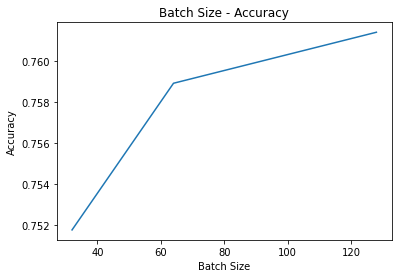

In [103]:
a = np.array(batch_size_array)
b = np.array(max_acc)

plt.plot(a, b)
plt.title("Batch Size - Accuracy")
plt.xlabel("Batch Size")
plt.ylabel("Accuracy")
plt.show()

As you can see above, we got best accuracy with batch_size=128 while learning rate and epochs number was constant. In the later parts of the modeling, the batch size  will be 128. 

In [40]:
acc_arr = []
for e_size in epoch_size_array:
  model.load_weights("model.h5")
  history_model = model.fit(X_train,y_train,batch_size=128,epochs=e_size,validation_split=0.2,callbacks=[reduce_lr])
  acc_arr.append(history_model.history['accuracy'])

for i in acc_arr:
  print("Max Accuracy:",max(i))

Epoch 1/5
51/51 [==============================] - 1s 15ms/step - loss: 1.2735 - accuracy: 0.6569 - recall: 0.4923 - auc: 0.8444 - val_loss: 1.2433 - val_accuracy: 0.6712 - val_recall: 0.0505 - val_auc: 0.8814
Epoch 2/5
51/51 [==============================] - 1s 12ms/step - loss: 1.1557 - accuracy: 0.6723 - recall: 0.6059 - auc: 0.8730 - val_loss: 1.2255 - val_accuracy: 0.6712 - val_recall: 0.1678 - val_auc: 0.8940
Epoch 3/5
51/51 [==============================] - 1s 12ms/step - loss: 1.1358 - accuracy: 0.6723 - recall: 0.6045 - auc: 0.8788 - val_loss: 1.2415 - val_accuracy: 0.6712 - val_recall: 0.2171 - val_auc: 0.8970
Epoch 4/5
51/51 [==============================] - 1s 12ms/step - loss: 1.1144 - accuracy: 0.6723 - recall: 0.5861 - auc: 0.8857 - val_loss: 1.2832 - val_accuracy: 0.6712 - val_recall: 0.1965 - val_auc: 0.8986
Epoch 5/5
51/51 [==============================] - 1s 12ms/step - loss: 1.0906 - accuracy: 0.6723 - recall: 0.5494 - auc: 0.8934 - val_loss: 1.2186 - val_accura

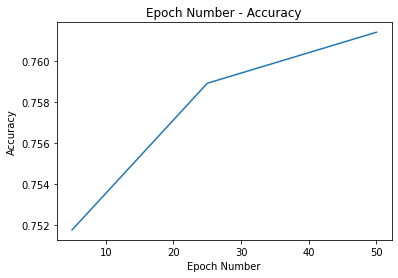

In [104]:
a = np.array(epoch_size_array)
b = np.array(max_acc)

plt.plot(a, b)
plt.title("Epoch Number - Accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")
plt.show()

When we look at the accuracy in different epochs number we see that best accuracy was epochs_size=50 while batch size and learning rate was constant. In the later parts of the modeling, the epochs number will be 50. 

In [27]:
acc_arr = []
for lr in learning_rates:
  model.load_weights("model.h5")
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_lr=lr)
  history_model = model.fit(X_train,y_train,batch_size=128,epochs=50,validation_split=0.2,callbacks=[reduce_lr])
  acc_arr.append(history_model.history['accuracy'])

for i in acc_arr:
  print("Max Accuracy:",max(i))

Epoch 1/50
51/51 [==============================] - 1s 13ms/step - loss: 1.2522 - accuracy: 0.6595 - recall: 0.5176 - auc: 0.8497 - val_loss: 1.2242 - val_accuracy: 0.6712 - val_recall: 0.2021 - val_auc: 0.8893
Epoch 2/50
51/51 [==============================] - 1s 12ms/step - loss: 1.1566 - accuracy: 0.6723 - recall: 0.6040 - auc: 0.8731 - val_loss: 1.2783 - val_accuracy: 0.6712 - val_recall: 0.0069 - val_auc: 0.8972
Epoch 3/50
51/51 [==============================] - 1s 12ms/step - loss: 1.1211 - accuracy: 0.6723 - recall: 0.6045 - auc: 0.8836 - val_loss: 1.2682 - val_accuracy: 0.6712 - val_recall: 0.2127 - val_auc: 0.9012
Epoch 4/50
51/51 [==============================] - 1s 12ms/step - loss: 1.0956 - accuracy: 0.6722 - recall: 0.5508 - auc: 0.8918 - val_loss: 1.1884 - val_accuracy: 0.6712 - val_recall: 0.3337 - val_auc: 0.9066
Epoch 5/50
51/51 [==============================] - 1s 12ms/step - loss: 1.0720 - accuracy: 0.6720 - recall: 0.5279 - auc: 0.8985 - val_loss: 1.1462 - val_a

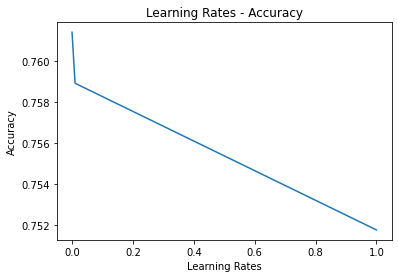

In [105]:
a = np.array(learning_rates)
b = np.array(max_acc)

plt.plot(a, b)
plt.title("Learning Rates - Accuracy")
plt.xlabel("Learning Rates")
plt.ylabel("Accuracy")
plt.show()

As you can see above, we got best accuracy with learning_rate=0.001 while batch size and epochs number was optimum. 
So we got the optimum hyperparameters;

                      batch_size = 128

                      epochs_number = 50

                      learning_rate =  0.0001


Now we train our model for last time with optimum CNN hyperparameters.

In [83]:
model.load_weights("model.h5")
early=EarlyStopping(monitor='val_loss',patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_lr=1E-4) 
history_model = model.fit(X_train,y_train,batch_size=128,epochs=50,validation_data=(X_test,y_test),callbacks=[reduce_lr,early])

Epoch 1/50
63/63 [==============================] - 1s 14ms/step - loss: 0.7760 - accuracy: 0.7184 - recall: 0.6037 - auc: 0.9493 - val_loss: 0.7417 - val_accuracy: 0.7284 - val_recall: 0.5826 - val_auc: 0.9546
Epoch 2/50
63/63 [==============================] - 1s 12ms/step - loss: 0.7702 - accuracy: 0.7193 - recall: 0.6076 - auc: 0.9501 - val_loss: 0.7403 - val_accuracy: 0.7339 - val_recall: 0.5776 - val_auc: 0.9560
Epoch 3/50
63/63 [==============================] - 1s 12ms/step - loss: 0.7591 - accuracy: 0.7223 - recall: 0.6115 - auc: 0.9515 - val_loss: 0.7809 - val_accuracy: 0.7249 - val_recall: 0.5202 - val_auc: 0.9537
Epoch 4/50
63/63 [==============================] - 1s 12ms/step - loss: 0.7616 - accuracy: 0.7188 - recall: 0.6052 - auc: 0.9511 - val_loss: 0.7371 - val_accuracy: 0.7349 - val_recall: 0.5701 - val_auc: 0.9562
Epoch 5/50
63/63 [==============================] - 1s 12ms/step - loss: 0.7619 - accuracy: 0.7255 - recall: 0.6117 - auc: 0.9511 - val_loss: 0.7604 - val_a

Let's move on Evaluation part.

# Evaluation <a class="anchor" id="evaluation"></a>

Firstly we want to show model accuracy graph. As you can see from the graphic, our model was able to learn from the training set even if it was not straight forward. 

We got 75% accuracy with optimum hyperparameters so we think that our model is successful to predict cancer types by looking lesions images.

       loss  accuracy    recall  ...  val_recall   val_auc      lr
0  0.776010  0.718422  0.603719  ...    0.582626  0.954608  0.0001
1  0.770230  0.719296  0.607589  ...    0.577634  0.956038  0.0001
2  0.759127  0.722292  0.611458  ...    0.520220  0.953719  0.0001
3  0.761575  0.718797  0.605217  ...    0.570145  0.956205  0.0001
4  0.761878  0.725537  0.611707  ...    0.534199  0.954793  0.0001

[5 rows x 9 columns]


<Figure size 1080x360 with 0 Axes>

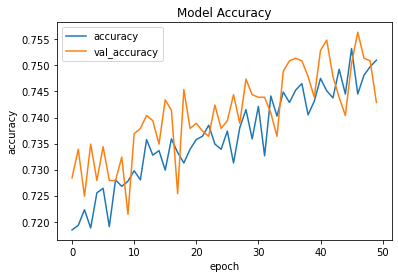

In [84]:
plt.figure(figsize=(15,5))
loss=pd.DataFrame(model.history.history)
print(loss.head())
loss=loss[['accuracy','val_accuracy']]
loss.plot(title="Model Accuracy", xlabel="epoch",ylabel="accuracy")


When we look at the model loss, it has always shown a downward trend. The downward trend of loss is another indicator of success for us.

<Figure size 1080x360 with 0 Axes>

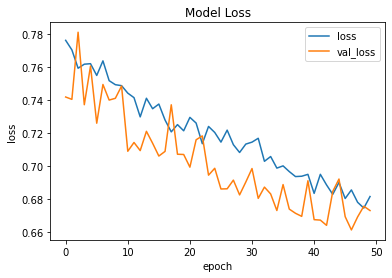

In [85]:
plt.figure(figsize=(15,5))
loss=pd.DataFrame(model.history.history)
loss=loss[['loss','val_loss']]
loss.plot(title="Model Loss", xlabel="epoch",ylabel="loss")

And also we got auc score to be sure our model success. Auc is a built-in metrics from tensorflow.keras.metrics.

<Figure size 1080x360 with 0 Axes>

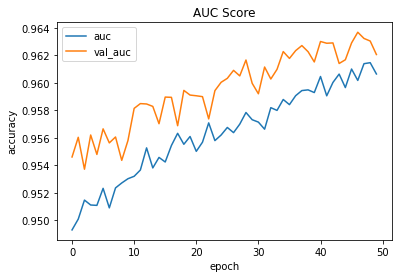

In [86]:
plt.figure(figsize=(15,5))
loss=pd.DataFrame(model.history.history)
loss=loss[['auc','val_auc']]
loss.plot(title="AUC Score", xlabel="epoch",ylabel="accuracy")

Here is our classification reports includes accuracy, macro avg, weighted avg.

In [57]:
predictions=model.predict_classes(X_test)

check=[]
for i in range(len(y_test)):
  for j in range(7):
    if(y_test[i][j]==1):
      check.append(j)
check=np.asarray(check)

print(classification_report(check,predictions))


              precision    recall  f1-score   support

           0       0.51      0.35      0.42        60
           1       0.46      0.65      0.54        97
           2       0.46      0.54      0.50       224
           3       0.00      0.00      0.00        27
           4       0.86      0.90      0.88      1320
           5       0.80      0.14      0.24        29
           6       0.54      0.42      0.47       246

    accuracy                           0.75      2003
   macro avg       0.52      0.43      0.43      2003
weighted avg       0.74      0.75      0.74      2003



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Here is our model.evaluate result. Our auc score is pretty high we say that our model has done a great job.

In [87]:
loss, acc, treshold,treshold2 = model.evaluate(X_test, y_test, verbose=2)


63/63 - 0s - loss: 0.6730 - accuracy: 0.7429 - recall: 0.6495 - auc: 0.9621


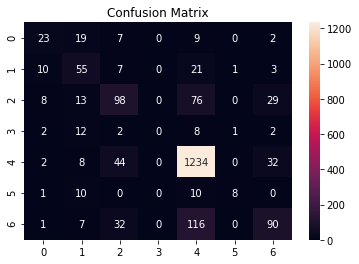

In [106]:
pred = model.predict(X_test)

matrix = metrics.confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1))

ax = plt.axes()    
sns.heatmap(matrix, annot=True, ax=ax,fmt='g')
ax.set_title('Confusion Matrix')
plt.show()

# References <a class="anchor" id="references"></a>

https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/#:~:text=The%20Keras%20deep%20learning%20neural,augmentation%20via%20the%20ImageDataGenerator%20class.&text=Image%20data%20augmentation%20is%20used,of%20the%20model%20to%20generalize.


https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c


https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class

https://thesai.org/Downloads/Volume10No6/Paper_38-Hyperparameter_Optimization_in_Convolutional_Neural_Network.pdf
